In [2]:
import argparse
import numpy as np 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.base import clone 
import matplotlib.pyplot as plt

np.random.seed(1234)

class FoursAndNines:
    """
    Class to store MNIST data
    """

    def __init__(self, location):

        import cPickle, gzip

        # Load the dataset
        f = gzip.open(location, 'rb')

        # Split the data set 
        train_set, valid_set, test_set = cPickle.load(f)

        # Extract only 4's and 9's for training set 
        self.x_train = train_set[0][np.where(np.logical_or( train_set[1]==4, train_set[1] == 9))[0],:]
        self.y_train = train_set[1][np.where(np.logical_or( train_set[1]==4, train_set[1] == 9))[0]]
        self.y_train = np.array([1 if y == 9 else -1 for y in self.y_train])
        
        # Shuffle the training data 
        shuff = np.arange(self.x_train.shape[0])
        np.random.shuffle(shuff)
        self.x_train = self.x_train[shuff,:]
        self.y_train = self.y_train[shuff]

        # Extract only 4's and 9's for validation set 
        self.x_valid = valid_set[0][np.where(np.logical_or( valid_set[1]==4, valid_set[1] == 9))[0],:]
        self.y_valid = valid_set[1][np.where(np.logical_or( valid_set[1]==4, valid_set[1] == 9))[0]]
        self.y_valid = np.array([1 if y == 9 else -1 for y in self.y_valid])
        
        # Extract only 4's and 9's for test set 
        self.x_test  = test_set[0][np.where(np.logical_or( test_set[1]==4, test_set[1] == 9))[0],:]
        self.y_test  = test_set[1][np.where(np.logical_or( test_set[1]==4, test_set[1] == 9))[0]]
        self.y_test = np.array([1 if y == 9 else -1 for y in self.y_test])
        
        f.close()



In [3]:
class AdaBoost:
    def __init__(self, n_learners=20, base=DecisionTreeClassifier(max_depth=1)):
        """
        Create a new adaboost classifier.
        
        Args:
            n_learners (int, optional): Number of weak learners in classifier.
            base (BaseEstimator, optional): Your general weak learner 

        Attributes:
            base (estimator): Your general weak learner 
            n_learners (int): Number of weak learners in classifier.
            alpha (ndarray): Coefficients on weak learners. 
            learners (list): List of weak learner instances. 
        """
        
        self.n_learners = n_learners 
        self.base = base
        self.alpha = np.zeros(self.n_learners)
        self.learners = []
        
    def fit(self, X_train, y_train):
        """
        Train AdaBoost classifier on data. Sets alphas and learners. 
        
        Args:
            X_train (ndarray): [n_samples x n_features] ndarray of training data   
            y_train (ndarray): [n_samples] ndarray of data 
        """

        # TODO 

        # Hint: You can create and train a new instantiation 
        # of your sklearn weak learner as follows 

#        w = np.ones(len(y_train))
#        h = clone(self.base)
#        h.fit(X_train, y_train, sample_weight=w)

        w = np.ones(len(y_train))/len(y_train)
        for k in range(self.n_learners):
            h = clone(self.base)
            h.fit(X_train, y_train, sample_weight=w)
            self.learners.append(h)

            prediction = h.predict(X_train)
            error = sum(w*abs(prediction-y_train))/(2*sum(w))
            accuracy = 0.5*np.log((1-error)/error)
            self.alpha[k] = accuracy

            w *= np.exp(-accuracy*y_train*prediction)
            w /= sum(w)

    def predict(self, X):
        """
        Adaboost prediction for new data X.
        
        Args:
            X (ndarray): [n_samples x n_features] ndarray of data 
            
        Returns: 
            [n_samples] ndarray of predicted labels {-1,1}
        """

        # TODO 
        predictions = np.sign(sum(self.alpha[k]*self.learners[k].predict(X) for k in range(self.n_learners)))
        
        return predictions

    
    def score(self, X, y):
        """
        Computes prediction accuracy of classifier.  
        
        Args:
            X (ndarray): [n_samples x n_features] ndarray of data 
            y (ndarray): [n_samples] ndarray of true labels  
            
        Returns: 
            Prediction accuracy (between 0.0 and 1.0).
        """

        # TODO 
        accuracy = 1 - sum(abs(self.predict(X) - y))/(2*X.shape[0])

        return accuracy
    
    def staged_score(self, X, y):
        """
        Computes the ensemble score after each iteration of boosting 
        for monitoring purposes, such as to determine the score on a 
        test set after each boost.
        
        Args:
            X (ndarray): [n_samples x n_features] ndarray of data 
            y (ndarray): [n_samples] ndarray of true labels  
            
        Returns: 
            [n_learners] ndarray of scores 
        """

        # TODO 
        n_samples = X.shape[0]
        consensus = np.zeros(n_samples)
        predictions = np.zeros(n_samples)
        accuracy = np.zeros(self.n_learners)
        for k in range(self.n_learners):
            consensus += self.alpha[k]*self.learners[k].predict(X)  # Total for prediction for each test example
            predictions = np.sign(consensus)  # Predictions for k learners
            accuracy[k] = 1 - sum(np.abs(predictions - y))/(2*n_samples) # If predictions

        return accuracy


def mnist_digit_show(flatimage, outname=None):

    import matplotlib.pyplot as plt

    image = np.reshape(flatimage, (-1,28))

    plt.matshow(image, cmap=plt.cm.binary)
    plt.xticks([])
    plt.yticks([])
    if outname: 
        plt.savefig(outname)
    else:
        plt.show()

def I(test):
    assert test in [True,False], "Recieved type " + str(type(test)) + " instead of bool"
    if(test): return 1
    else: return -0

In [31]:
# if __name__ == "__main__":

parser = argparse.ArgumentParser(description='AdaBoost classifier options')
parser.add_argument('--limit', type=int, default=-1,
                    help="Restrict training to this many examples")
parser.add_argument('--n_learners', type=int, default=50,
                    help="Number of weak learners to use in boosting")
parser.add_argument('-f', type=str)
args = parser.parse_args()

data = FoursAndNines("../data/mnist.pkl.gz")
scale = 1
x_train = data.x_train[:int(scale*data.x_train.shape[0])]
y_train = data.y_train[:int(scale*data.y_train.shape[0])]
x_test = data.x_test[:int(scale*data.x_test.shape[0])]
y_test = data.y_test[:int(scale*data.y_test.shape[0])]
print("%d training samples" %(len(y_train),))
print("%d test samples" %(len(y_test),))

# An example of how your classifier might be called 
#clf = AdaBoost(n_learners=100, base=DecisionTreeClassifier(max_depth=1, criterion="entropy"))
#clf.fit(data.x_train[:int(scale*data.x_train.shape[0])], data.y_train[:int(scale*data.y_train.shape[0])])
def find_accuracy(clf):
    accuracy = np.ones((2, clf.n_learners))
    accuracy[0] -= clf.staged_score(x_train,y_train)
    accuracy[1] -= clf.staged_score(x_test,y_test)

    return accuracy

def build_graph(accuracy, title):
    plt.figure()
    fig = plt.gcf()
    plt.plot(range(n), accuracy.T)
    plt.legend(("Training Error","Test Error"), loc="best")
    plt.title(title)
    plt.xlabel("# Learners")
    plt.ylabel("Error")
    plt.show()
    fig.savefig("%s.png" %(title,))
    
n = 500
depth_list = [1,2,3]
clf_models = []
# Boosted Stump Classifier
print("Training Boosted Stump Classifiers")
for depth in depth_list:
    title = "Boosted Stump Classifier, depth= %s" %(depth,)
    clf = AdaBoost(n_learners=n, base=DecisionTreeClassifier(max_depth=depth, criterion="entropy"))
    clf.fit(x_train, y_train)
    clf_models.append((title,clf))
    print("\t%s Trained!" %(title,))
print("Boosted Stump Classifiers Trained")

# Perceptron Classifier
print("Training Boosted Perceptron Classifiers")
for n_iterations in depth_list:
    title = "Boosted Perceptron Classifier n_iter= %s" %(n_iterations,)
    clf = AdaBoost(n_learners=n, base=Perceptron(n_iter=n_iterations))
    clf.fit(x_train, y_train)
    clf_models.append((title,clf))
    print("\t%s Trained!" %(title,))
print("Boosted Perceptron Classifiers Trained")
    
print("Models Ready")

9847 training samples
1991 test samples
Training Boosted Stump Classifiers
	Boosted Stump Classifier, depth= 1 Trained!
	Boosted Stump Classifier, depth= 2 Trained!
	Boosted Stump Classifier, depth= 3 Trained!
Boosted Stump Classifiers Trained
Training Boosted Perceptron Classifiers
	Boosted Perceptron Classifier n_iter= 1 Trained!
	Boosted Perceptron Classifier n_iter= 2 Trained!
	Boosted Perceptron Classifier n_iter= 3 Trained!
Boosted Perceptron Classifiers Trained
Models Ready


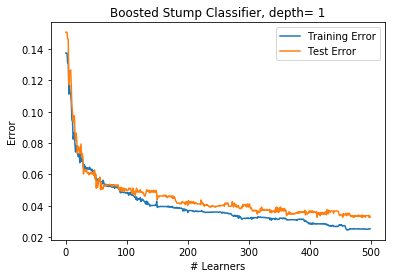

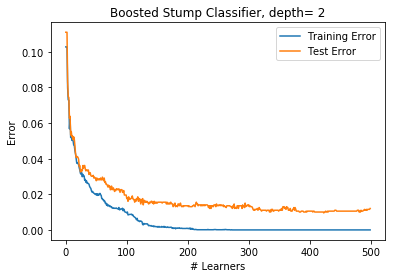

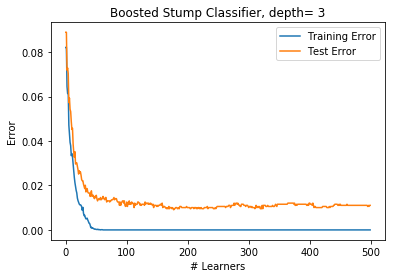

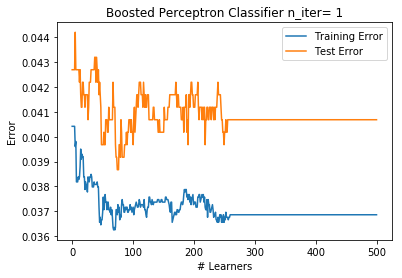

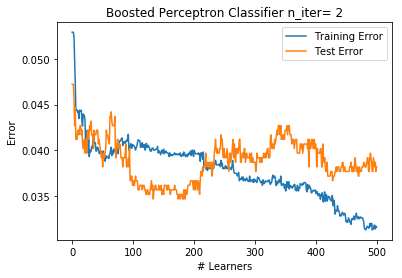

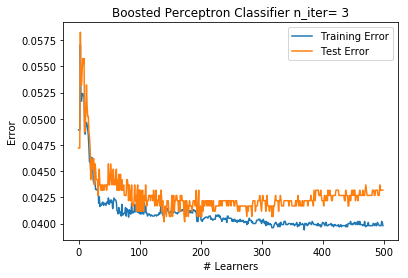

In [32]:
for clf in clf_models:
    accuracy = find_accuracy(clf[1])
    build_graph(accuracy,clf[0])